In [68]:
import os
import torch
import minari

import matplotlib.pyplot as plt
import statistics as stat
import numpy as np
import seaborn as sns

import torch.nn.functional as F
from torch import nn, Tensor
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

from tqdm import tqdm

In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [70]:
def collate_fn(batch):
    observations = [torch.as_tensor(x.observations['observation']) for x in batch]
    lengths = torch.tensor([obs.shape[0] for obs in observations])  # Tensor of original lengths

    # Pad with zeros first
    padded_obs = torch.nn.utils.rnn.pad_sequence(observations, batch_first=True)

    # Use advanced indexing to replace padding with the last valid value
    mask = torch.arange(padded_obs.shape[1]).expand(len(batch), -1) >= lengths.unsqueeze(1)
    padded_obs[mask] = padded_obs[torch.arange(len(batch)), lengths - 1].unsqueeze(1).expand_as(padded_obs)[mask]

    return {
        # "id": torch.tensor([x.id for x in batch]), # Vurder å fjerne ID fra collate s.a. det blir lettere å processere senere.
        "observations": padded_obs
    }

In [71]:
dataset = minari.load_dataset('D4RL/pointmaze/umaze-v2')
print(f"Total amount of episodes: {dataset.total_episodes}")  # 13210 episodes
batch_size = 64

dataLoader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)
for batch in dataLoader:
    test_batch = batch['observations']
    print(f"test_batch.shape: {test_batch.shape}")
    break

Total amount of episodes: 13210
test_batch.shape: torch.Size([64, 179, 4])


## Dataset trajectory example
* One episode
* Based on the 'Observation' parameter of Observations.

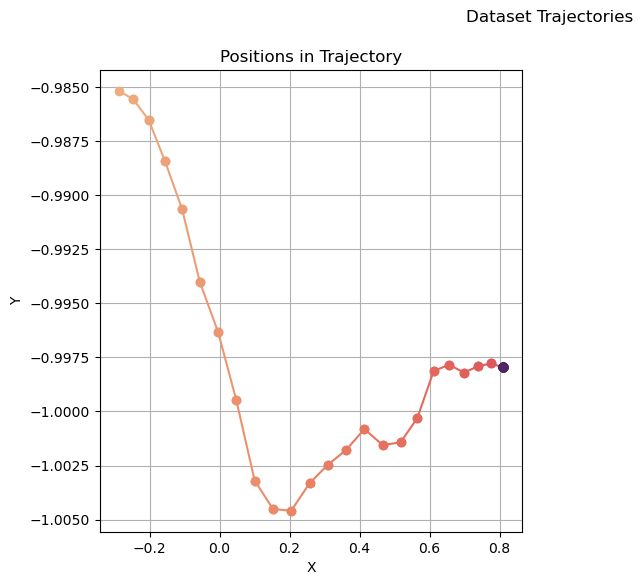

In [72]:
colors = sns.color_palette("flare", len(test_batch))

plt.figure(figsize=(12, 6))

# Plot positions
plt.subplot(1, 2, 1)
for i in range(len(test_batch) - 1): # Traj plot
    plt.plot(test_batch[0, i:i+2, 0].cpu().numpy(), test_batch[0, i:i+2, 1].cpu().numpy(), color=colors[i], marker='o')
plt.title('Positions in Trajectory')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()

plt.suptitle('Dataset Trajectories')
plt.show()

## FLOW MATCHING

* TODO: Se på x_t uttrykket, og hva funksjonen tar inn
* Sjekk sampling output (shape)
* Sjekk at loss går nedover med trening
* Skriv i overleaf hva treningsfunksjon skal være, og sampling prosedyre
* Så implementer loss beregning og sampling.

In [73]:
# Sample from the dataset with shape (batch_size, ??) = x1
# x0 will be torch.randn_like(x1)
# target = x1- x0
# Generate timesteps equal to size of first dim of x1: torch.rand(x1.size(0))
# xt = (1 - t[:, None, ??]) * x0 + t[:, None] * x1
# prediction = model(xt, t)
# loss ((target - prediction)**2).mean()

In [74]:
class TrajectoryFlowModel(nn.Module):
    def __init__(self, obs_dim, hidden_dim=128, num_layers=3):
        """
        A neural network that estimates the velocity field for flow matching.
        
        Args:
            obs_dim (int): Dimensionality of observations (D_obs)
            hidden_dim (int): Number of hidden units in the MLP
            num_layers (int): Number of layers in the MLP
        """
        super().__init__()
        
        layers = []
        input_dim = obs_dim + 1  # We include time `t` as an input
        
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim  # Keep hidden layer size consistent
        
        layers.append(nn.Linear(hidden_dim, obs_dim))  # Output has the same shape as observations
        self.network = nn.Sequential(*layers)

    def forward(self, x, t):
        """
        Forward pass for the trajectory flow model.
        """
        # print(f"t.shape in model code: {t.shape}")
        sec_dim = x.shape[1]
        t_expanded = t[:, None, None].expand(-1, sec_dim, -1)
        xt = torch.cat([x, t_expanded], dim=-1).to(device, dtype=torch.float32)
        velocity = self.network(xt)  # Predict flow field

        return velocity  # Shape: (N, T, D_obs)

In [115]:
epochs = 10
lr = 3e-3 # Learning rate

traj_dim = xt.shape[2] # 4 | [xpos, ypos, xvel, yvel]
flow_model = TrajectoryFlowModel(traj_dim).to(device)
optimizer = torch.optim.Adam(flow_model.parameters(), lr=lr)

xt_prog = []
losses = []

for epoch in tqdm(range(epochs), desc="Training Progress"):
    for batch in dataLoader:
        observations = batch['observations']
        x1 = observations[torch.randint(observations.size(0), (batch_size, ))].to(device)
        x0 = torch.rand_like(x1).to(device)
        vel_target = x1 - x0 # dxt
        t = torch.rand((x1.size(0),), device=device)
        # print(f"Shapes: \nx1: {x1.shape}\nx0: {x0.shape}\nt: {t.shape}\nt in xt: {t[:, None, None].shape}")
        xt = t[:, None, None] * x1 + (1 - t[:, None, None]) * x0 # See eq. (2.3) i guide and code s.5
        xt_prog.append(xt)
        prediction = flow_model(xt, t)
        # print(f"Shape of prediction: {prediction.shape}")
        loss = ((vel_target - prediction)**2).mean()
        loss = loss.to(device, dtype=torch.float32)
        # print(f"Loss: {loss}")
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())

Training Progress: 100%|██████████| 10/10 [04:07<00:00, 24.73s/it]


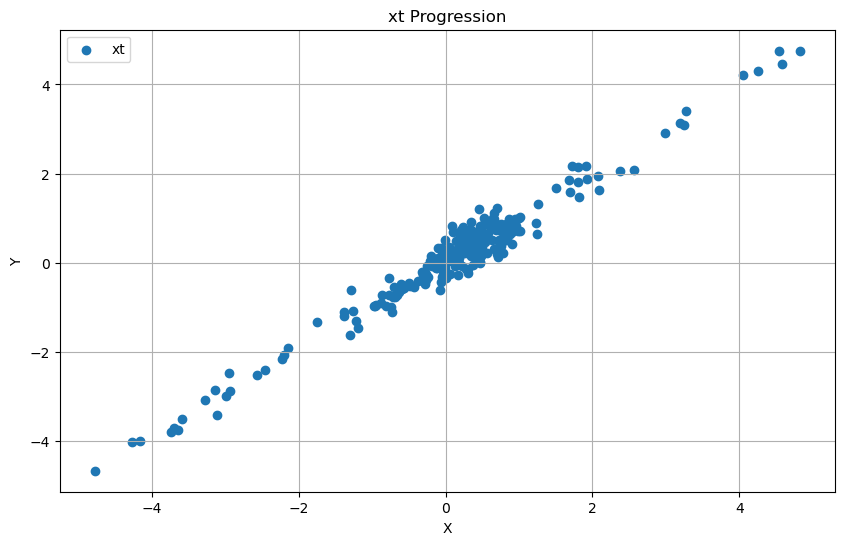

In [116]:
xt_lst = []
for ver in xt_prog:
    ver = ver.cpu().numpy()
    xt_lst.append(ver)
plt.figure(figsize=(10, 6))
plt.scatter(xt_lst[0][:, 0], xt_lst[0][:, 1], label='xt', marker='o')
plt.title('xt Progression')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

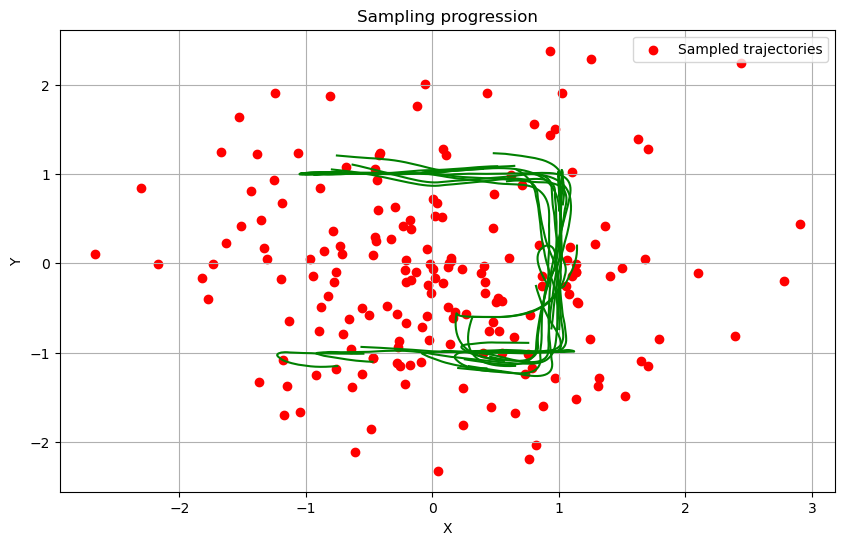

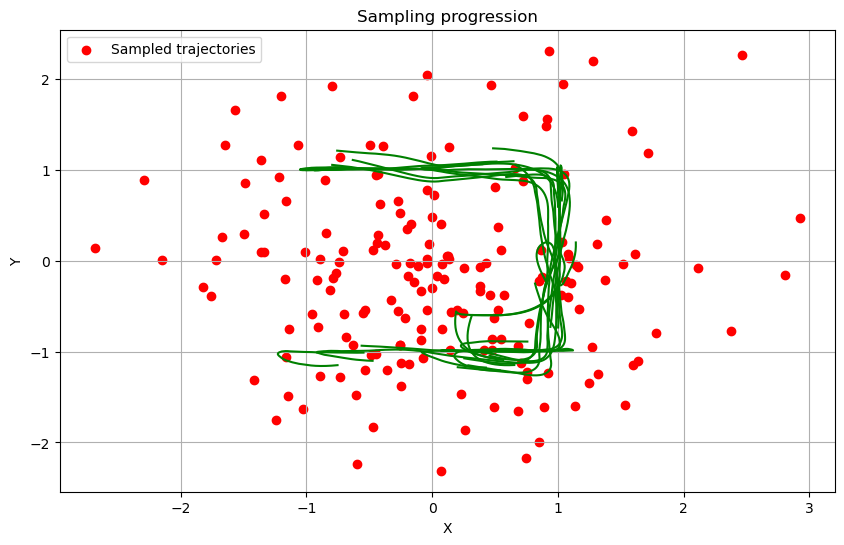

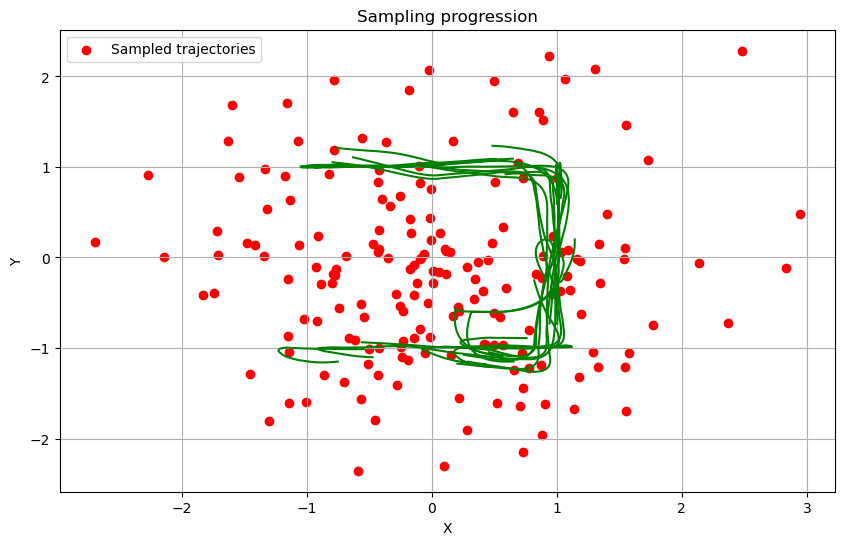

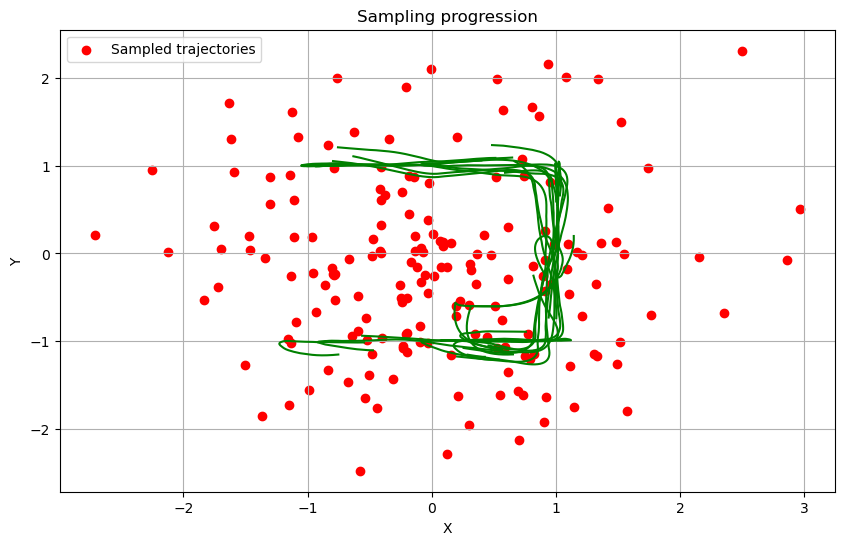

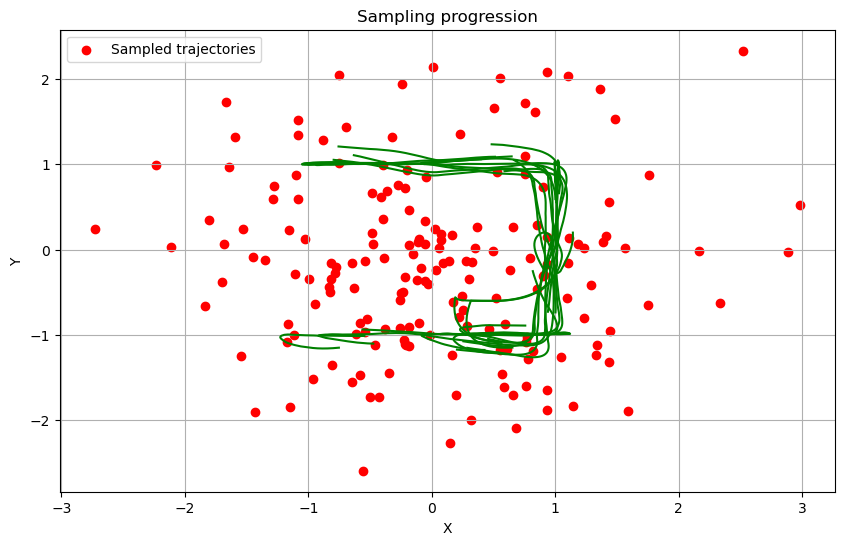

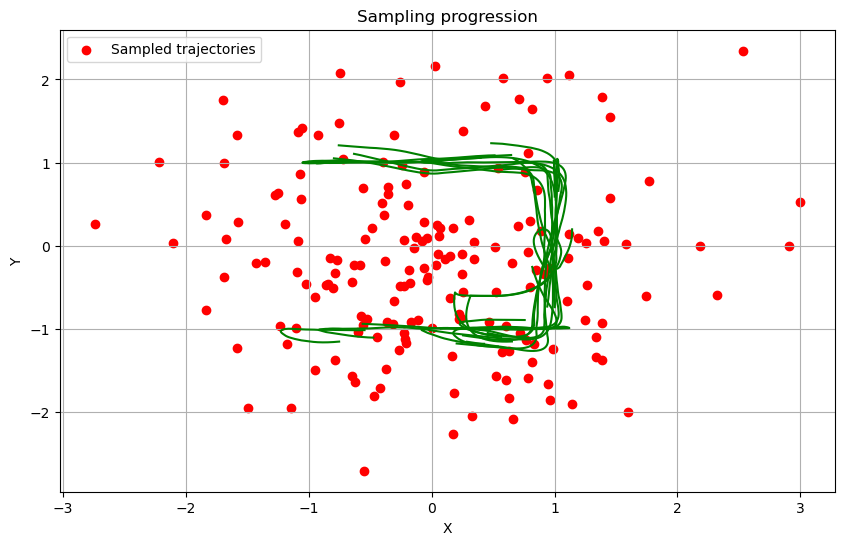

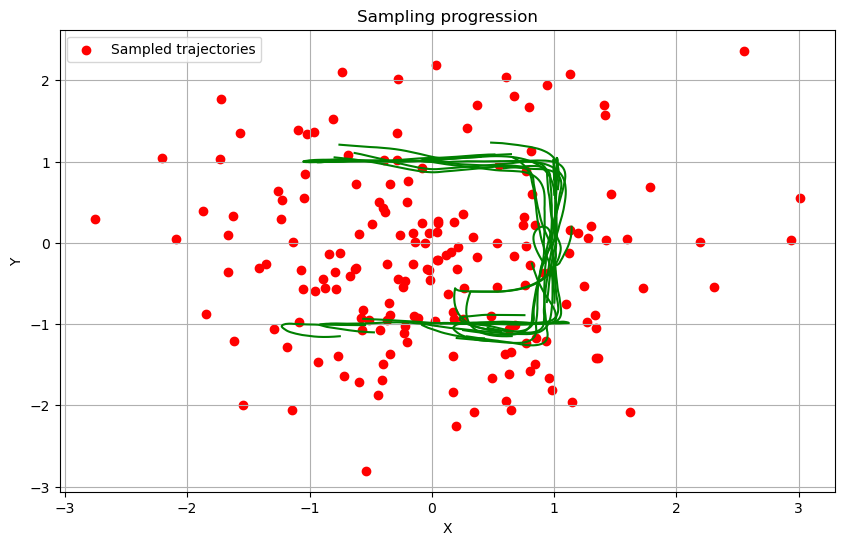

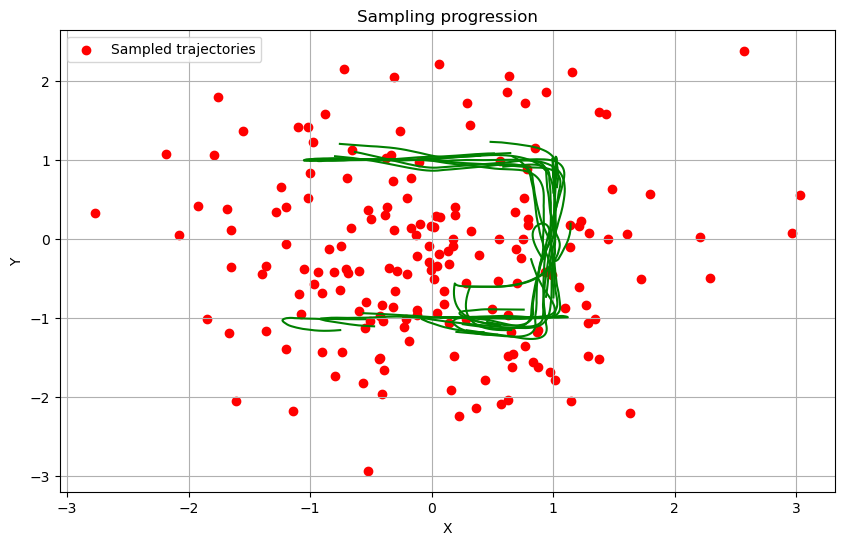

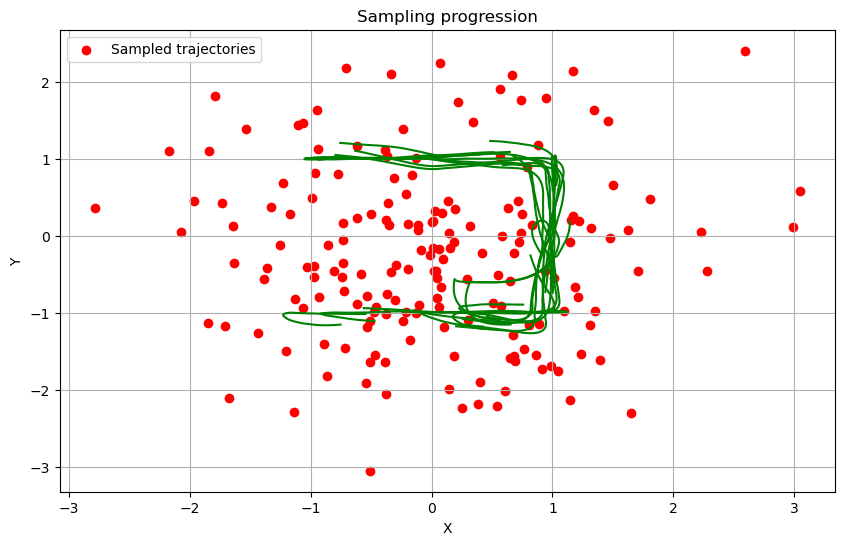

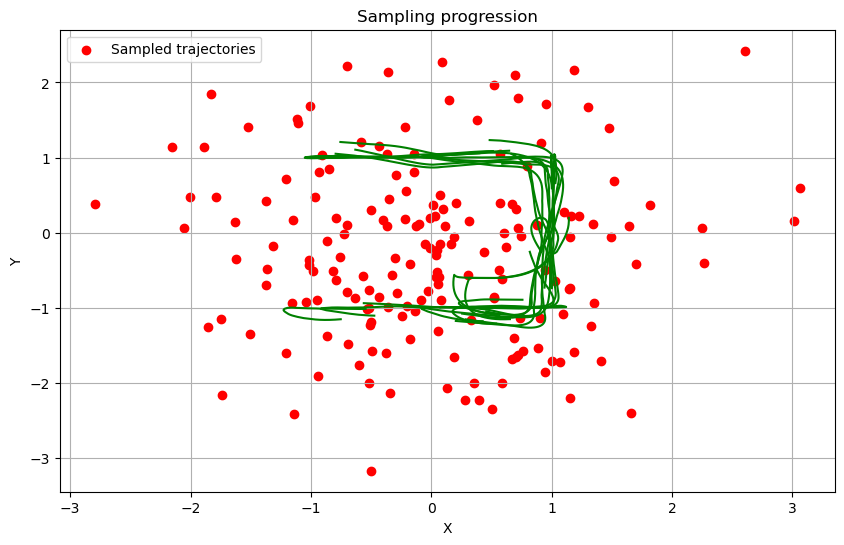

Finished sampling


In [144]:
sampling_steps = 1000
plot_every = 100

sample_trajs = torch.randn_like(xt)
flow_model.eval().requires_grad_(False)
max_steps = min(observations.size(1), sample_trajs.size(1))

observation_lst = []
max_batches = 20
for count, batch in enumerate(dataLoader):
    if count == max_batches:
        break
    obs = batch['observations']
    observation_lst.append(obs)

for i, t in enumerate(torch.linspace(0, 1, sampling_steps), start = 1):
    t = torch.rand(xt.size(0)).to(device)
    pred = flow_model(xt, t)
    sample_trajs = sample_trajs + (1 / sampling_steps) * pred # Vurder å implementere step funksjon som gir ODE solver med midpoint method her.

    if i % plot_every == 0:
        plt.figure(figsize=(10, 6))
        # plt.plot(observations[0, i:i+2, 0].cpu().numpy(), observations[0, i:i+2, 1].cpu().numpy(), color='g', label="Dataset trajectories")
        # plt.plot(sample_trajs[0, i:i+2, 0].cpu().numpy(), sample_trajs[0, i:i+2, 1].cpu().numpy(), color='r', label="Sampled trajectories")
        for observations in observation_lst:
            plt.plot(observations[0, :, 0].cpu().numpy(), observations[0, :, 1].cpu().numpy(), color='g')
        plt.scatter(sample_trajs[0, :, 0].cpu().numpy(), sample_trajs[0, :, 1].cpu().numpy(), color='r', label="Sampled trajectories")
        plt.title('Sampling progression')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid()
        plt.legend()
        plt.show()
flow_model.train().requires_grad_(True)
print("Finished sampling")

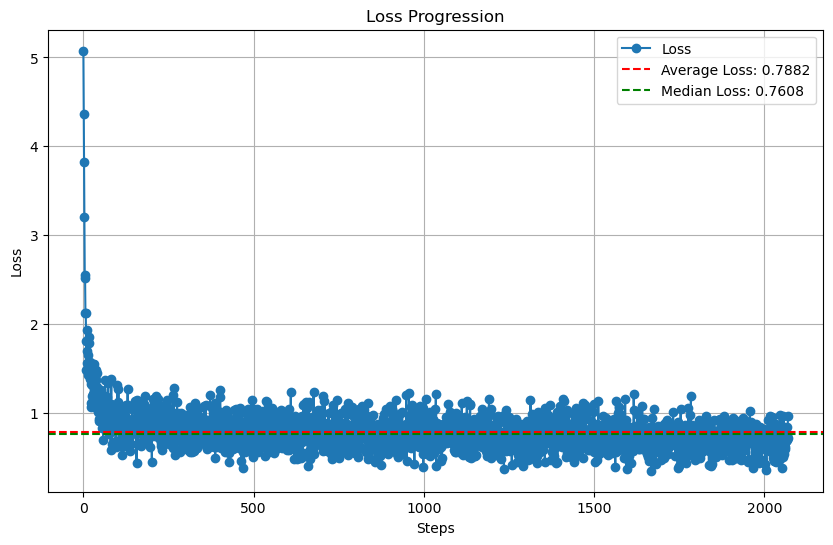

In [ ]:
avg_loss = sum(losses)/len(losses)
med_loss = stat.median(losses)

save_dir = 'Plotted loss'
os.makedirs(save_dir, exist_ok=True)
plot_path = os.path.join(save_dir, 'loss_plot.png')

plt.figure(figsize=(10, 6))
plt.plot(losses, label='Loss', marker='o')
plt.axhline(y=avg_loss, color='r', linestyle='--', label=f'Average Loss: {avg_loss:.4f}')
plt.axhline(y=med_loss, color='g', linestyle='--', label=f'Median Loss: {med_loss:.4f}')
plt.title('Loss Progression')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(plot_path)
plt.show()

## Sampling

* Implement ODE solver
* Generate noisy trajectories
* Display
* Store

In [ ]:
def sample_fm(model, noisy_trajs, sampling_steps=10000, plot_every=1000):
    torch.manual_seed(42)
    model.eval().requires_grad_(False)

    trajs = noisy_trajs.clone()
    num_trajs, traj_length, D_Obs = trajs.shape

    for i, t in enumerate(torch.linspace(0, 1, sampling_steps), start=1):
        t_expanded = t.expand(num_trajs, traj_length, 1).to(device)
        
        # Prediction
        pred = model(trajs, t_expanded)
        pred = pred.view(num_trajs, traj_length, D_Obs)

        trajs = trajs + (1 / sampling_steps) * pred
        if i % plot_every == 0 or i == sampling_steps:
            plt.figure(figsize=(6, 6))
            for traj in trajs:
                plt.plot(traj[:, 0].detach().cpu().numpy(), traj[:, 1].detach().cpu().numpy(), alpha=0.8, color='r')
                break
            plt.title(f'Step {i}')
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.grid()
            plt.show()
        
    model.train().requires_grad_(True)
    print("Done Sampling")
    return trajs


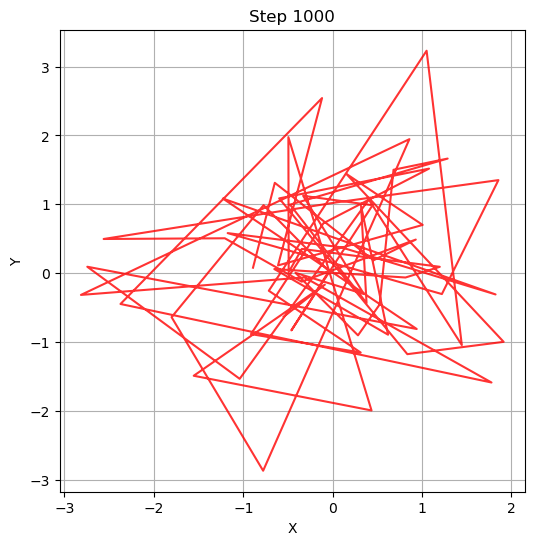

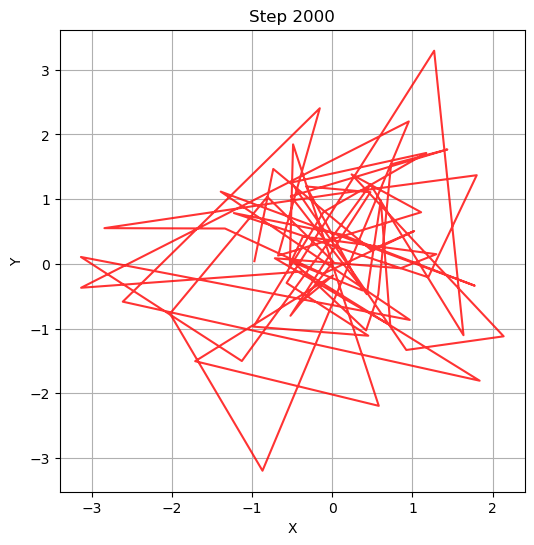

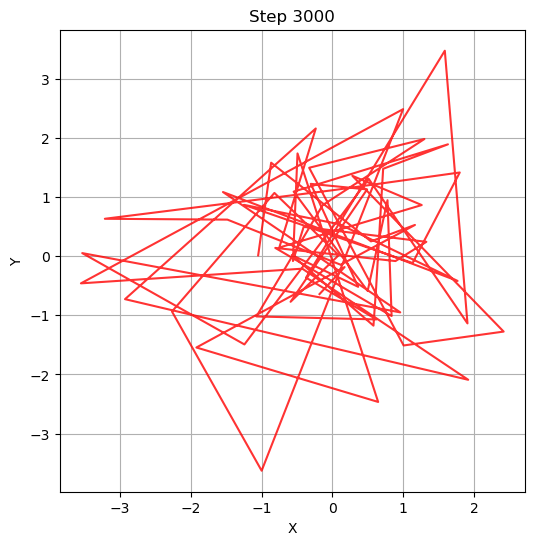

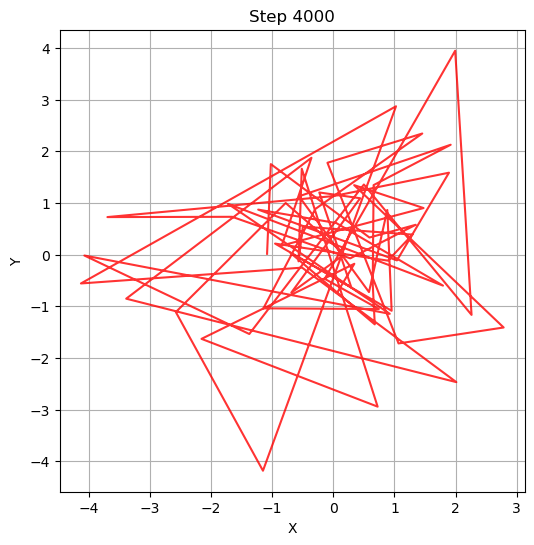

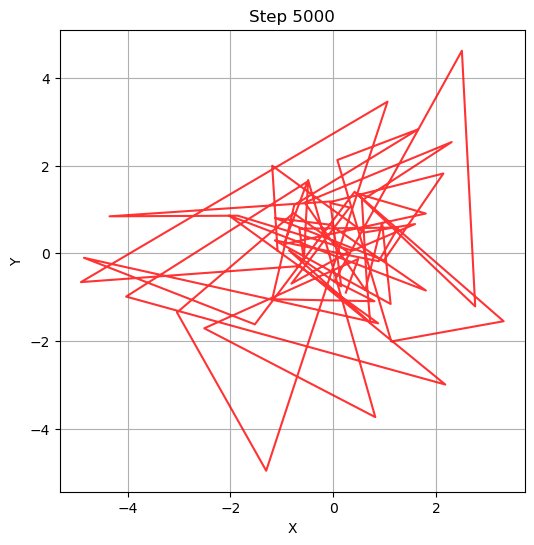

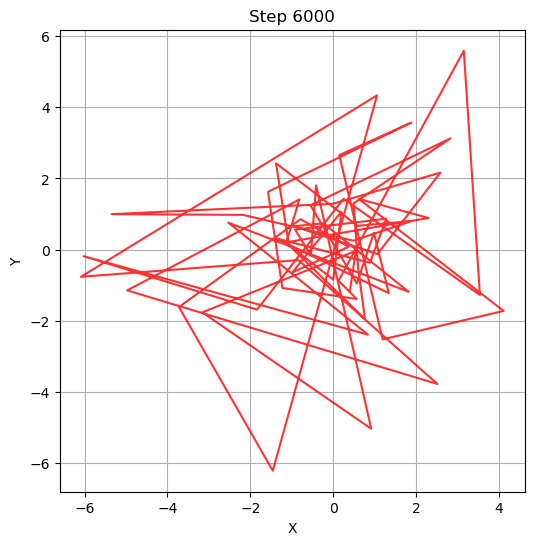

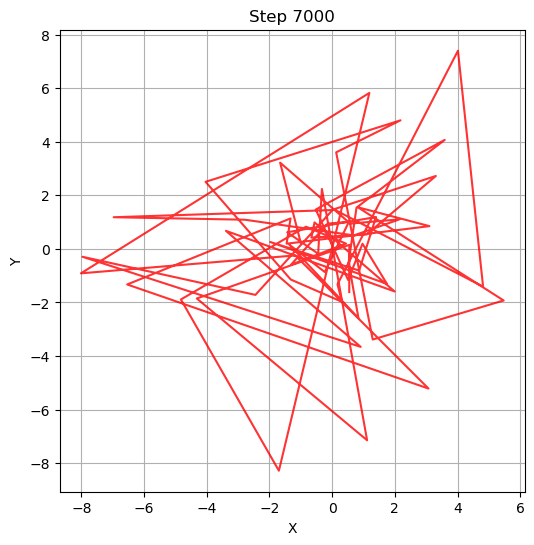

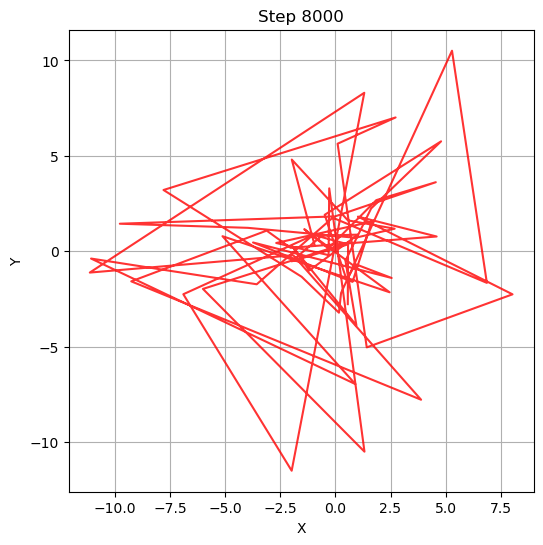

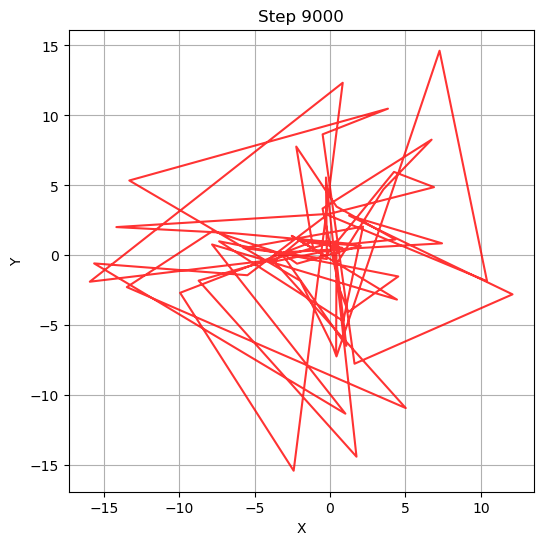

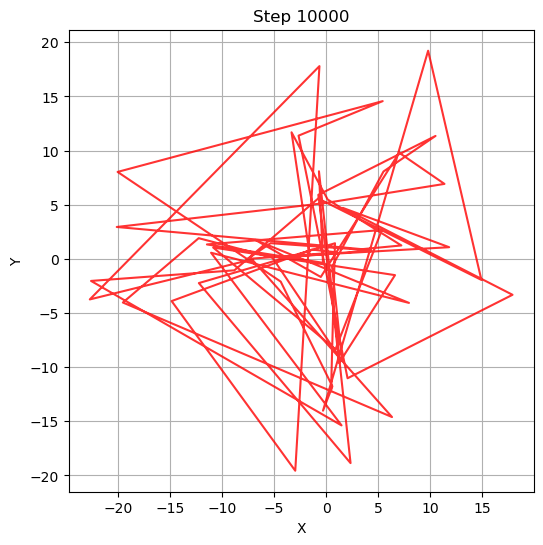

Done Sampling


In [ ]:
sampled_trajs = sample_fm(model, noisy_trajs)